## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [ ]:
X_train.shape

(7352, 128, 9)

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [ ]:
batch_size = 500

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class TSModel(nn.Module):
    def __init__(self, input_size, n_hidden, n_layers = 2, n_classes = 6, bias = True, batch_first = False):
        super(self.__class__, self).__init__()
        self.rnn = nn.LSTM(input_size, n_hidden, n_layers,  bias = bias, batch_first = batch_first)
        self.class_fc =  nn.Linear(n_hidden, n_classes)
    
    def forward(self, x): #(batch_size, timestamps, input_size)
        x = x.permute((1, 0, 2))
        outputs, h = self.rnn(x)
        output = outputs[-1] # (batch_size, n_hidden)
        output = self.class_fc(output)
        logits = F.log_softmax(output,dim=-1)
        return logits
    

In [ ]:
torch.eye(n_classes, dtype=torch.int)

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]], dtype=torch.int32)

In [6]:
def to_one_hot(x, n_classes = 6):
    return torch.eye(n_classes)[x.view(-1)]

def loop(model, dataloader, device = 'cuda', opt = None, loss_func = None, n_classes = 6):
    losses = []
    accuracies = []
    
    for ts_batch, ts_label in dataloader:
        
        ts_batch = ts_batch.to(device)
        
        labels_ohe = to_one_hot(ts_label.to(torch.int64), n_classes = n_classes)
        labels_ohe = labels_ohe.to(device)
        
        logits = model(ts_batch)
        loss = loss_func(logits, labels_ohe)
        
        losses.append(loss.detach().cpu().numpy())
        
        probas = F.softmax(logits, dim = -1)
        probas = probas.detach().cpu().numpy()
        y_pred = np.argmax(probas, axis = -1)
        current_acc = accuracy_score(ts_label.detach().numpy(), y_pred)
        accuracies.append(current_acc)
        
        if opt:
            loss.backward()
            opt.step()
            opt.zero_grad()
    
    mean_acc = np.array(accuracies).mean()
    mean_loss = np.array(losses).mean()
    
    return mean_loss, mean_acc


In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

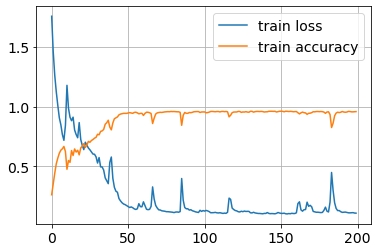

In [ ]:
model = TSModel(input_size = 9, n_hidden = n_hidden).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=0.0025, weight_decay=0.0015) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
epochs = 200
# Your experiments, come here
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
    train_loss, train_acc = loop(model, train_dataloader, loss_func = loss_func, opt = opt, device = device)
    model.train()
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    clear_output(True)
    plt.plot(train_losses, label='train loss')
    plt.plot(train_accs, label='train accuracy')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_loss, test_acc = loop(model, test_dataloader, loss_func=loss_func)
test_loss,test_acc

(0.38541296, 0.9073005219985086)

In [ ]:
save_is_need=False

In [ ]:
if save_is_need:
    path = 'model_score_0907.pt'
    torch.save(model,path)

In [ ]:
test_loss,test_acc

(0.3870338, 0.9070633855331841)

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

На самом деле, изначально подумал, что использую LSTM, но при этом не одну, а стак из нескольких. Хотел пойти от маленького, то есть от 2-х. Зашел в репозиторий, который был прикреплен и оказалось, что суть там та же, и поэтому взял лишь оттуда гиперпараметры для обучения и сразу получил хороший скор, правда  в первый раз он был около 0.89
После чего попробовал использовать 3 слоя LSTM, но там результат лишь ухудшился. Я получил около 0.86 на тренировочном датасете, после чего прекратил эксперементировать т.к. посчитал, что 0.89 подойдет. Обучил модель еще раз и выбил score 0.907, что очень близко к 0.91 (: Но т.к. далал поздно по датам, то решил не пытаться добить до 0.907, а потрогать 2-ю задачу

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [8]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import shutil
from os import walk

In [9]:
def copy_files_to_folder(base_paths, copied_paths, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for from_path, to_path in zip(base_paths, copied_paths):
        shutil.copyfile(from_path, to_path)

def get_files_from_dir(root):
    files = []
    for (dirpath, dirnames, filenames) in walk(root):
        files.extend(filenames)
    return files

def get_folders_from_dir(root):
    folders = []
    for (dirpath, dirnames, filenames) in walk(root):
        folders.append(dirpath)
    return folders[1:]

def create_file_names(root, paths_filenames):
    copy_paths = []
    for fn_path in paths_filenames:
        file_name = os.path.basename(fn_path)
        copy_paths.append(root+'/'+file_name)
    return copy_paths

def create_image_folder_split(base_root, copy_root = './data/splitted/', test_size=0.20,random_state=42):
    train_copy_path = copy_root+'train/'
    test_copy_path = copy_root+'test/'
    folders = get_folders_from_dir(base_root)
    print(folders)
    for class_folder in folders:
        class_files = get_files_from_dir(class_folder)
        
        X_train, X_test, _,_  = train_test_split(class_files, class_files, test_size=test_size, random_state=random_state)
        
        lf_name = os.path.basename(os.path.normpath(class_folder))
        
        new_train_path = train_copy_path+'/'+lf_name+'/'
        copy_train_paths = create_file_names(new_train_path, X_train)
        from_train_paths = create_file_names(class_folder, X_train)
        copy_files_to_folder(from_train_paths, copy_train_paths, new_train_path)
        
        new_test_path = test_copy_path+'/'+lf_name+'/'
        from_test_paths = create_file_names(class_folder, X_test)
        copy_test_paths = create_file_names(new_test_path, X_test)
        copy_files_to_folder(from_test_paths, copy_test_paths, new_test_path)

Разделим на тренировочную и валидационную выборки, дабы понимать как хорошо учится модель

In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/train/32/109.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
create_image_folder_split('/content/data/train')

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

root_test =  '/content/data/splitted/test'
root_train  = '/content/data/splitted/train'

train_dataset = ImageFolder(root_train, transform=test_transform)
test_dataset = ImageFolder(root_test, transform=test_transform)


train_dogloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dogloader = DataLoader(test_dataset, batch_size=4)

In [12]:
len(train_dogloader),len(test_dogloader)

(1429, 363)

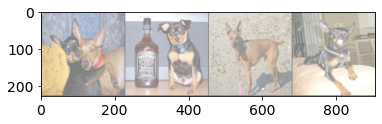

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_dogloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
!pip install transformers

In [115]:
from transformers import AutoFeatureExtractor, ViTForImageClassification
base_model = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')


In [32]:
1280*7*7

62720

In [51]:
class TSModel(nn.Module):
    def __init__(self, base_model, n_hidden,
                 n_classes = 50):
        super(self.__class__, self).__init__()
        self.base_model = base_model
        self.n_nidden = n_hidden
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.class_fc =  nn.Linear(n_hidden, n_classes)
    
    def forward(self, x): #(batch_size, timestamps, input_size)
        output = self.base_model(x)
        output = output.reshape((x.shape[0], self.n_nidden))
        cls_output = self.class_fc(output) 
        
        logits = F.log_softmax(cls_output, dim=-1)
        return logits

In [52]:
from torchvision.models import mobilenet_v3_large,MobileNet_V3_Large_Weights

# Using pretrained weights:
base_model = mobilenet_v3_large(weights="MobileNet_V3_Large_Weights.IMAGENET1K_V2")
base_model = torch.nn.Sequential(*(list(base_model.children())[:-1]))

In [53]:
with torch.no_grad():
  output = base_model(images)

In [54]:
output.shape

torch.Size([4, 960, 1, 1])

In [55]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [78]:
train_dataset = ImageFolder('/content/data/train', transform=test_transform)
train_dogloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

0.9374835225674916


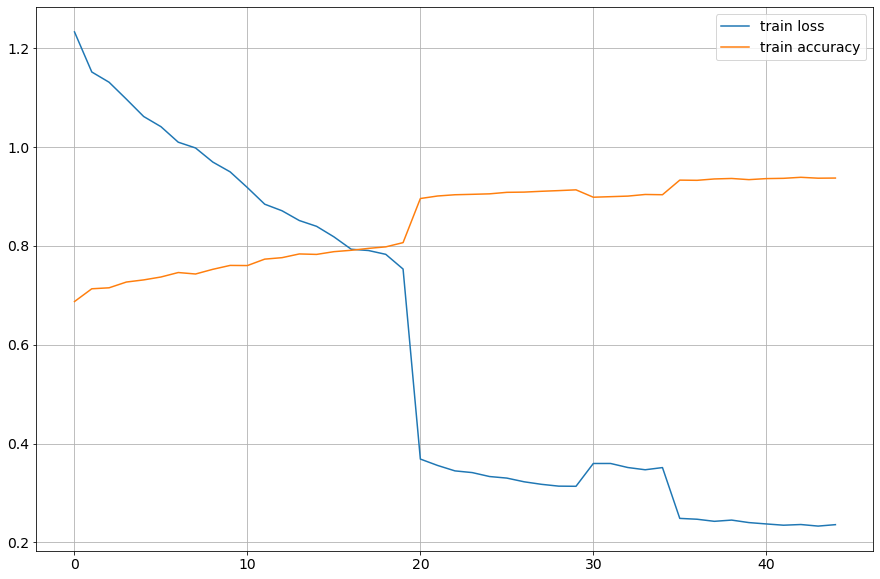

In [79]:
model = TSModel(base_model, 960).to(device)
opt = torch.optim.SGD(model.parameters(), 3e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
epochs = 50
n_classes = 50
# Your experiments, come here
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
    train_loss, train_acc = loop(model, train_dogloader, device = device, 
                                 loss_func=loss_func, 
                                 opt = opt, 
                                 n_classes=n_classes)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    clear_output(True)
    plt.figure(figsize=(15, 10))
    print(train_accs[-1])
    plt.plot(train_losses, label='train loss')
    plt.plot(train_accs, label='train accuracy')
    plt.grid()
    plt.legend()
    plt.show()

In [80]:
torch.save(model, '/content/drive/MyDrive/ML/mobilenet_v3_large.pt')

In [81]:
torch.save(opt, '/content/drive/MyDrive/ML/vmobilenet_v3_large.pt')

In [94]:
import pandas as pd
from PIL import Image

In [92]:
files_names = get_files_from_dir('/content/data/last/test')
files = create_file_names('/content/data/last/test', files_names)

In [98]:
image_to_tensor = transforms.ToTensor()
def from_path_to_tensor(path):
  img = Image.open(path)
  return image_to_tensor(img)

In [102]:
output_map = {'image_name':[], 'label':[]}
for path in files:  
  file_name = os.path.basename(os.path.normpath(path))
  ts_batch = from_path_to_tensor(path).to(device)
  ts_batch = ts_batch.reshape((1, *ts_batch.shape))
  
  with torch.no_grad():
    logits = model(ts_batch)
        
  probas = F.softmax(logits, dim = -1)
  probas = probas.detach().cpu().numpy()
  y_pred = np.argmax(probas, axis = -1)
  
  output_map['label'].append(y_pred[0])
  output_map['image_name'].append(file_name)

In [103]:
output_df = pd.DataFrame(output_map)

In [106]:
output_df.to_csv('predictions.csv',index=False,header=False)

Пробовал несколько архитектур:
1. Сначала пытался использовать в качестве backbone facebook/deit-small-patch16-224 с Linear слоем для классификации и optimizer AdamW. За 10 эпох получился accuracy 0.65 и сеть начала переобучаться. При этом там было под 30 миллионов параметров.
2. Дальше пытался использовать resnet50 с Adam и sgd оптимизатором, но слишком уж много параметров и обучить не удалось.

3. После чего решил взять маленькую модель modelMobile. Там за 10 эпох удалось добиться accuracy=0.83, но дальше казалось, что рости не будет, при этом отказался от Adam,AdamW и т.п., перейдя к обычному sgd потому что нехватало памяти.

4. Далее решил поисследовать mobilenet  модели и оказалось,  что mobilenet_v3_large показывает хороший score (выше он). На самом деле график не  полный, обучал 30 эпох с разделением на train_dogloader, test_dogloader но loss и accuracy был хуже, чем у элементов test_dogloader, далее решил объедениить два датасета, чтобы дать модели больше информации (после того как увидел, что переобучение не наблюдается) и с 30-й до 50-й эпохи обучение происходило уже на полном датасете

5. После чего решил поисследовать regnet_x_1_6gf. С таким же подходо, как описано выше, но модель выдала те же самые результаты по accuracy. (смотреть график ниже)

## regnet_x_1_6gf

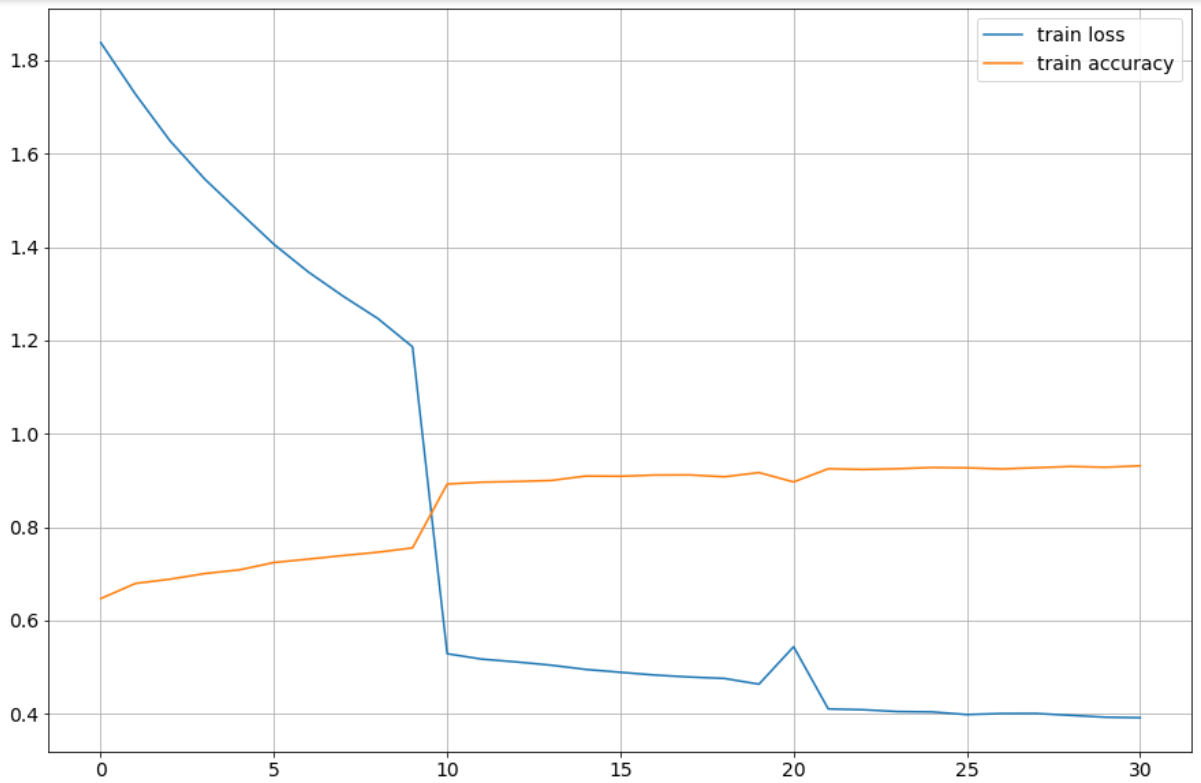